In [1]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt


# Utils
from pyspecter.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Jax
from jax import grad, jacobian, jit
import jax.numpy as jnp
from jax import random

# SPECTER
# from pyspecter.SpectralEMD_Helper import compute_spectral_representation, train_step

2023-11-01 12:23:39.208043: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.41 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(100, 150, 3)
Max # of particles: 132


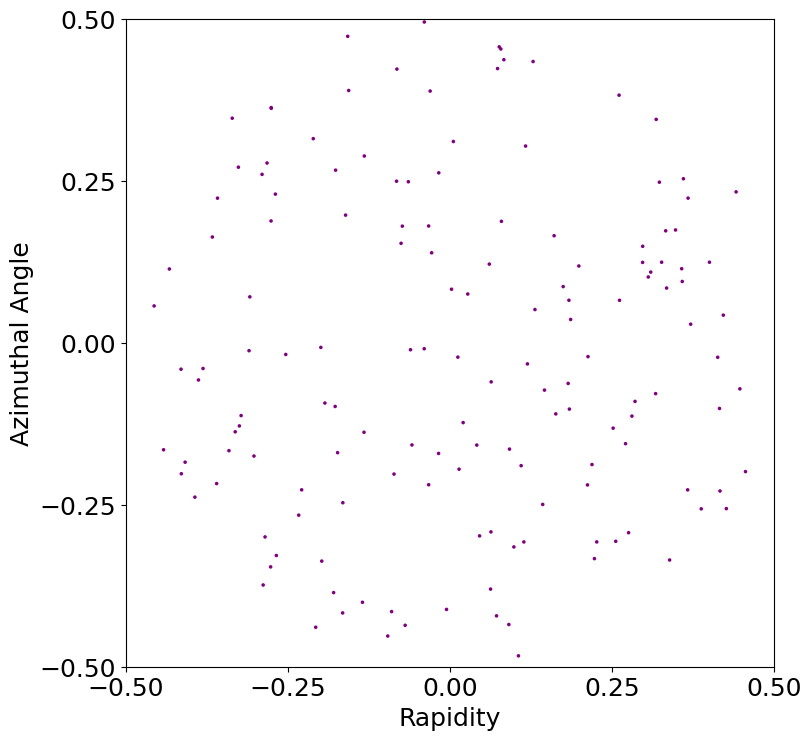

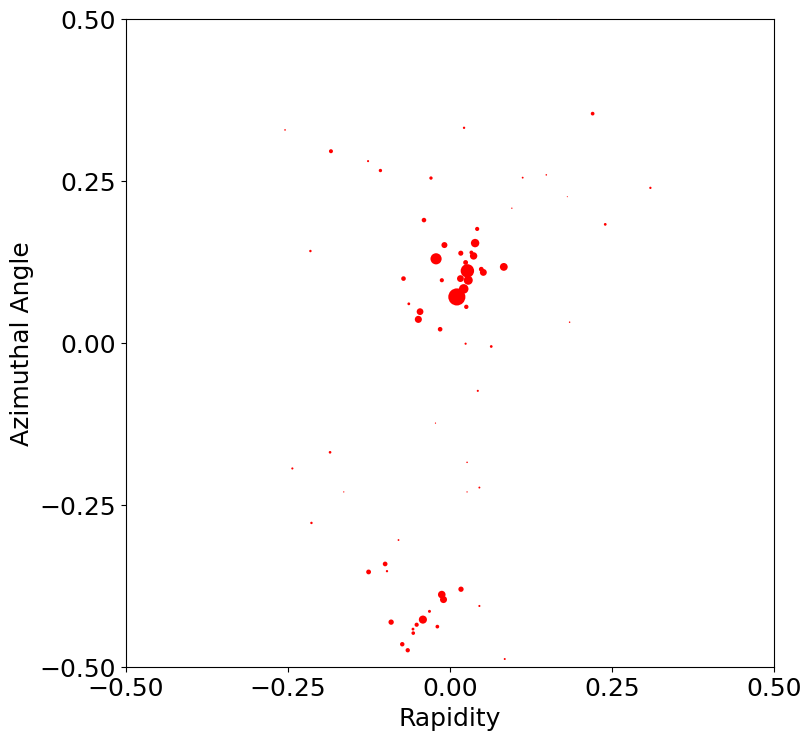

<Axes: xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [ ]:
# TODO: Fix JIT compiler
def disk_sampler(batch_size, N, R, seed = 0):

        # Random seed
        key = random.PRNGKey(seed)
        key1, key2 = random.split(key)

        # For a spiral -- use the same random key!
        phi = 2 * jnp.pi * random.uniform(key1, shape = (batch_size, N))
        r = jnp.sqrt( random.uniform(key2, shape = (batch_size, N)))

        x = R * r * jnp.cos(phi)
        y = R * r * jnp.sin(phi)
        e = jnp.ones_like(r) / N
        points = jnp.stack((e, x, y), axis = -1)

        return points

%timeit disks = disk_sampler(100, 150, 0.5)
disks = disk_sampler(100, 150, 0.5)
print(disks.shape)
dataset_open, sim_weights, k = load_cmsopendata("~/.energyflow/", "sim", 475, 525, 1.9, 2, pad = 75, n = 10000)


example_event = disks[0]
plot_event(example_event[:,1:], example_event[:,0], R = 0.5, color = "purple")



example_event = dataset_open[0]
plot_event(example_event[:,1:], example_event[:,0], R = 0.5, color = "red")


In [ ]:
# @jax.jit
def compute(s, sampler, parameters = 0, alpha = 1e-3, epochs = 1000):

    batch_size = s.shape[0]

    initializer_kwargs = {"R" : 0.5}

    if parameters == 0:
        events = sampler(batch_size, 150, seed = 0, **initializer_kwargs)
        
        losses = np.zeros((1, batch_size))
        sEMD2s = train_step(epoch, s, events, return_grads = False)
        losses[0] = sEMD2s


        return sEMDs, events, losses



    

In [ ]:
# sEMDs
from tqdm import tqdm
import jax


@jax.jit
def train_step(epoch, s, sprongs):

        
    sEMDS = ds2(sprongs, s)
    grads = gradients(sprongs, s)

    return sEMDS, grads

    opt_state = opt_update(epoch, grads, opt_state)
    return opt_state, sEMDS, sprongs


# @jax.jit
def compute_2spronginess(s, alpha = 1e-3):

    batch_size = s.shape[0]
    epochs = 1000



    initial_omega = 0.5
    initial_2ee = 0.2

    # Initialize 2-prong events
    sprongs = np.zeros((batch_size, 2, 2))
    sprongs[:,0,:] = (0, 1-initial_2ee)
    sprongs[:,1,:] = (initial_omega, initial_2ee)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(sprongs)

    # ts = []
    # ss = []

    for epoch in range(epochs):

        sprongs = get_params(opt_state)
        sEMDs, grads = train_step(epoch, s, sprongs)
        opt_state = opt_update(epoch, grads, opt_state)


    # plt.scatter(ts,ss)
    return sEMDs, sprongs







sEMDs_2, sprongs = compute_2spronginess(s, 1e-2)
sEMDs_3, sprongs = compute_2spronginess(s, 1e-3)


sEMDs = np.zeros((N,N))
sEMDs[ij_indices[:,0], ij_indices[:,1]] = sEMDs_3


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
plt.xlabel("Opening Angle")
plt.ylabel("Particle 1 Energy")
plt.axvline(np.pi/3, ls = "--", color = "grey")
plt.axhline(2/3, ls = "--", color = "grey")

plt.title("2-sPronginess [Unphysical]")
plt.colorbar()
# plt.clabel("log$_{10}d^2$")






plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# print(angles.shape, np.array(EMDs).shape)

# plt.plot(angles, 2 * np.square(np.array(EMDs)), color = "black", label = r"$\beta$(2-Pronginess)$^\beta$")
plt.plot(angles, np.array(sEMDs_3.reshape((N,N))[:,120]), color = "red", label = r"$\alpha = 10^{-3}$")
plt.plot(angles, np.array(sEMDs_2.reshape((N,N))[:,120]), color = "black", label = r"$\alpha = 10^{-2}$")

plt.axvline(np.pi / 3, color = "grey", ls = "--")
plt.legend(frameon = False, title = "2-sPronginess")

plt.xlabel("Opening Angle [Rad]")
plt.ylabel("Observable")





# def compute_d2prong(angle):

#     sEMDs = []


#     s2prongs = []
#     es = np.linspace(0,0.5, 50)
#     omegas = np.linspace(0,1.5,150)
#     ij = []
#     for (i, e) in enumerate(es):
#         for (j, omega) in enumerate(omegas):
#             s2 = np.array((   (0, 1 - e), (omega, e),     ))
#             s2prongs.append(s2)
#             ij.append((i,j))
#     s2prongs = np.array(s2prongs)
#     ij = np.array(ij)
        


#     indices = [int(angle * 180/np.pi)] * 50*150
#     equilateral_triangles = s[indices]


#     sEMDs = ds2(s2prongs, equilateral_triangles)
#     temp = np.zeros((50,150))
#     temp[ij[:,0], ij[:,1]] = sEMDs

#     argmin = np.unravel_index(np.argmin(temp, axis=None), temp.shape)
#     print(argmin)
#     print(temp[argmin], temp[44,100])
#     plt.imshow(temp)

#     return np.amin(sEMDs)


# compute_d2prong(0)

# # angle_sEMDs = []
# # for angle in tqdm(angles[:-1]):
# #     angle_sEMDs.append(compute_d2prong(angle))








# for angle in tqdm(range(N)):


#     bee = []

#     for energy in range(N):

#         es = np.linspace(0,0.5, 100)
#         omegas = np.array((1,))
#         Es, Omegas = np.meshgrid(es, omegas)
#         temp = np.zeros_like(Es)
    

#         for (i, e) in enumerate(es):
#             for (j, omega) in enumerate(omegas):

#                 s = compute_spectral_representation(events[angle][energy], type = "jet")
#                 s2 = np.array((   (0, 1 - e), (omega, e),     ))
#                 d = ds2(s, s2)
#                 temp[j,i] = d

#         bee.append(np.amin(temp))
#     sEMDs.append(bee)

# sEMDs = np.array(sEMDs)

NameError: name 's' is not defined

In [ ]:
from pyspecter.SpectralEMD_Helper import ds2, compute_spectral_representation

@jax.jit
def compute_spectral_representation_jax(events, omega_max = 2, is_jet = True, dtype = jnp.float32):

    # events shape is (batch_size, pad, 3)
    points, zs = events[:,:,1:], events[:,:,0]
    batch_size = zs.shape[0]
    euclidean_distance_squared = jnp.sum(jnp.square(points[:,:, None, :] - points[:,None, :, :]), axis=-1)
    

    # # Upper Triangle Matrices
    # if not is_jet:
    #     omega_ij = jnp.triu(euclidean_distance_squared / 2)
    # elif is_jet:


    omega_ij = jnp.triu(euclidean_distance_squared, k = 1)
    triangle_indices = jnp.triu_indices(zs.shape[1], k = 1)



    triangle_indices_i = triangle_indices[0]
    triangle_indices_j = triangle_indices[1]


    ee_ij = jnp.triu(zs[:,:,None] * zs[:,None,:])
    ee2 = jnp.trace(ee_ij, axis1 = 1, axis2=2)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij[:,triangle_indices_i, triangle_indices_j]
    if is_jet:
        omega_n = jnp.sqrt(omega_n)
    ee_n = 2 * ee_ij[:,triangle_indices_i, triangle_indices_j]


    s = jnp.stack((omega_n, ee_n), axis = 1)
    s = jnp.transpose(s, (0,2,1))
    
    # Sort and append 0
    indices = s[:,:,0].argsort()
    temp_indices = jnp.arange(batch_size)[:,jnp.newaxis]
    s = s[temp_indices,indices]
    s0 = jnp.zeros((batch_size, 1, 1))
    s1 = jnp.concatenate((s0, jnp.expand_dims(ee2, axis = (1,2))), axis = 2)
    s = jnp.concatenate((s1, s), axis = 1)

    return s.astype(dtype)


s_jax = compute_spectral_representation_jax(dataset_open) 
print(s_jax.shape)



@jax.jit
def physical_ds2(events, s):

    sprongs = compute_spectral_representation_jax(events)
    sEMDs = ds2(sprongs, s)

    return sEMDs

def sum_function(f):
    def sum_f(events, s):
        return jnp.sum(f(events, s))
    return sum_f


temp_sum  = sum_function(physical_ds2)
print(temp_sum(dataset_open, s[::-1]))
physical_gradients = grad(sum_function, argnums=0)

print(physical_gradients(dataset_open, s[::-1]))
    

(10000, 2776, 2)


NameError: name 's' is not defined

In [ ]:
# sEMDs
from tqdm import tqdm
import jax.example_libraries.optimizers as jax_opt

@jax.jit
def train_step(epoch, s, events):

        
    sEMDS = physical_ds2(events, s)
    grads = physical_gradients(events, s)

    return sEMDS, jnp.nan_to_num(grads)

    opt_state = opt_update(epoch, grads, opt_state)
    return opt_state, sEMDS, sprongs



def project(events):

    temp = jnp.copy(events)
    zs = events[:,:,0]
    num_particles = events.shape[1]
    batch_size = events.shape[0]

    cnt_n = jnp.arange(num_particles)
    cnt_i = jnp.arange(batch_size)

    u = jnp.sort(zs, axis = -1)[:,::-1]
    v = (jnp.cumsum(u, axis = -1)-1) / (cnt_n + 1)
    w = v[cnt_i, jnp.sum(u > v, axis = -1) - 1]
    temp2 = temp.at[:,:,0].set(jnp.maximum(zs - w[:,None], 0))

    return temp2



# @jax.jit
def compute_physical_2spronginess(s, alpha = 1e-3, epochs = 1000):

    batch_size = s.shape[0]


    initial_R = 0.5
    initial_e = 0.8

    # Initialize 2-prong events
    events = np.zeros((batch_size, 2, 3))
    events[:,0,:] = (initial_e, 0, 0)
    events[:,1,:] = (1 - initial_e, 0, initial_R)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(events)

    losses = np.zeros((epochs, batch_size))

    for epoch in range(epochs):

        events = get_params(opt_state)
        events = project(events)
        sEMDs, grads = train_step(epoch, s, events)
        opt_state = opt_update(epoch, grads, opt_state)

        losses[epoch] = sEMDs
        


    return sEMDs, events, losses



def compute_physical_3spronginess(s, alpha = 1e-3, epochs = 1000):

    batch_size = s.shape[0]


    initial_R = 0.5
    initial_e = 0.8

    # Initialize 2-prong events
    events = np.zeros((batch_size, 3, 3))
    events[:,0,:] = (initial_e, 0, 0)
    events[:,1,:] = ((1 - initial_e)/2, initial_R, 0)
    events[:,2,:] = ((1 - initial_e)/2, 0, initial_R)

    # Optimizer
    opt_state = None
    opt_init, opt_update, get_params = jax_opt.adam(alpha)
    opt_state = opt_init(events)

    losses = np.zeros((epochs, batch_size))

    for epoch in range(epochs):

        events = get_params(opt_state)
        events = project(events)
        sEMDs, grads = train_step(epoch, s, events)
        opt_state = opt_update(epoch, grads, opt_state)

        losses[epoch] = sEMDs
        


    return sEMDs, events, losses




# sEMDs_2, events, l = compute_physical_2spronginess(s, 1e-2)
# sEMDs_3, events, l = compute_physical_2spronginess(s, 1e-3)

# print(sEMDs_3)


# sEMDs = np.zeros((N,N))
# sEMDs[ij_indices[:,0], ij_indices[:,1]] = sEMDs_3


# plt.rcParams.update({'font.size': 20})
# fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8)) 


# plt.contourf(angles, energies, np.log10(sEMDs.T), cmap = "Blues", levels = 25)
# plt.xlabel("Opening Angle")
# plt.ylabel("Particle 1 Energy")
# plt.axvline(np.pi/3, ls = "--", color = "grey")
# plt.axhline(2/3, ls = "--", color = "grey")

# plt.title("2-sPronginess [Unphysical]")
# plt.colorbar()
# # plt.clabel("log$_{10}d^2$")






# plt.rcParams.update({'font.size': 20})
# fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# # print(angles.shape, np.array(EMDs).shape)

# # plt.plot(angles, 2 * np.square(np.array(EMDs)), color = "black", label = r"$\beta$(2-Pronginess)$^\beta$")
# plt.plot(angles, np.array(sEMDs_3.reshape((N,N))[:,120]), color = "red", label = r"$\alpha = 10^{-3}$")
# plt.plot(angles, np.array(sEMDs_2.reshape((N,N))[:,120]), color = "black", label = r"$\alpha = 10^{-2}$")

# plt.axvline(np.pi / 3, color = "grey", ls = "--")
# plt.legend(frameon = False, title = "2-sPronginess")

# plt.xlabel("Opening Angle [Rad]")
# plt.ylabel("Observable")





# # def compute_d2prong(angle):

# #     sEMDs = []


# #     s2prongs = []
# #     es = np.linspace(0,0.5, 50)
# #     omegas = np.linspace(0,1.5,150)
# #     ij = []
# #     for (i, e) in enumerate(es):
# #         for (j, omega) in enumerate(omegas):
# #             s2 = np.array((   (0, 1 - e), (omega, e),     ))
# #             s2prongs.append(s2)
# #             ij.append((i,j))
# #     s2prongs = np.array(s2prongs)
# #     ij = np.array(ij)
        


# #     indices = [int(angle * 180/np.pi)] * 50*150
# #     equilateral_triangles = s[indices]


# #     sEMDs = ds2(s2prongs, equilateral_triangles)
# #     temp = np.zeros((50,150))
# #     temp[ij[:,0], ij[:,1]] = sEMDs

# #     argmin = np.unravel_index(np.argmin(temp, axis=None), temp.shape)
# #     print(argmin)
# #     print(temp[argmin], temp[44,100])
# #     plt.imshow(temp)

# #     return np.amin(sEMDs)


# # compute_d2prong(0)

# # # angle_sEMDs = []
# # # for angle in tqdm(angles[:-1]):
# # #     angle_sEMDs.append(compute_d2prong(angle))








# # for angle in tqdm(range(N)):


# #     bee = []

# #     for energy in range(N):

# #         es = np.linspace(0,0.5, 100)
# #         omegas = np.array((1,))
# #         Es, Omegas = np.meshgrid(es, omegas)
# #         temp = np.zeros_like(Es)
    

# #         for (i, e) in enumerate(es):
# #             for (j, omega) in enumerate(omegas):

# #                 s = compute_spectral_representation(events[angle][energy], type = "jet")
# #                 s2 = np.array((   (0, 1 - e), (omega, e),     ))
# #                 d = ds2(s, s2)
# #                 temp[j,i] = d

# #         bee.append(np.amin(temp))
# #     sEMDs.append(bee)

# # sEMDs = np.array(sEMDs)

In [ ]:
events = np.array((
((0.25,), (0.25,), (0.25,), (0.25,),),
((0.5,), (0.25,), (0.25,), (0.25,),),
))

print(project(events))

[[[0.25  ]
  [0.25  ]
  [0.25  ]
  [0.25  ]]

 [[0.4375]
  [0.1875]
  [0.1875]
  [0.1875]]]


In [ ]:
dataset_open, sim_weights = load_cmsopendata("~/.energyflow/", "cms", 475, 525, 1.9, 2, pad = 75, n = 10000)
s_jax_open = compute_spectral_representation_jax(dataset_open)

Max # of particles: 137


In [ ]:
sEMDs_real, events, losses = compute_physical_2spronginess(s_jax_open, 1e-2, epochs = 1000)

ValueError: Incompatible shapes for broadcasting: shapes=[(40000, 2), (40000,)]

In [ ]:
sEMDs_real3, events3, losses3 = compute_physical_3spronginess(s_jax_open, 1e-2, epochs = 1000)

In [ ]:
bins = 150
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

# plt.hist(sEMDs_real, color = "blue", alpha = 0.25, bins = bins)
plt.hist(sEMDs_real, color = "blue", histtype="step", lw = 3, bins = bins)
plt.yscale('log')
plt.title("CMS2011AJets", loc = "right")
plt.xlabel("N-sPronginess")


# plt.hist(sEMDs_real, color = "blue", alpha = 0.25, bins = bins)
plt.hist(sEMDs_real3, color = "darkblue", histtype="step", lw = 3, bins = bins)
plt.yscale('log')
plt.title("CMS2011AJets", loc = "right")
plt.xlabel("N-sPronginess")


# #######################

plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  

_2ee = 2 * events[:,0,0] * events[:,1,0]


plt.hist(_2ee, color = "blue", alpha = 0.25, bins = bins)
plt.hist(_2ee, color = "blue", histtype="step", lw = 3, bins = bins)
plt.yscale('log')
plt.title("CMS2011AJets", loc = "right")
plt.xlabel("$2E_1E_2$")



# #######################


plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  


plt.plot(np.mean(losses, axis = 1))
plt.yscale('log')
